In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary #https://github.com/sksq96/pytorch-summary
torch.manual_seed(1234)
np.random.seed(1234)

In [3]:
class dense_ae(nn.Module):
    def __init__(self, inputsize, bottleneck):
        super(dense_ae, self).__init__()
        self.linear1 = nn.Linear(inputsize,100)
        self.activation = nn.ReLU()
        self.activationS = nn.Sigmoid()
        self.linear2 = nn.Linear(100,50)
        self.linear3 = nn.Linear(50, bottleneck)
        self.linear4 = nn.Linear(bottleneck,50)
        self.linear5 = nn.Linear(50,100)
        self.linear6 = nn.Linear(100,inputsize)
        
    def forward(self, x):
        out = self.linear1(x)
        out = self.activationS(out)
        out = self.linear2(out)
        out = self.activationS(out)
        out = self.linear3(out)
        out = self.activationS(out)
        out = self.linear4(out)
        out = self.activationS(out)
        out = self.linear5(out)
        out = self.activationS(out)
        out = self.linear6(out)
        out = self.activationS(out)
        
        #out = out.view(out.size(0), -1)
        #return self.linear3(out)
        
        return out

test = dense_ae(201,20)
summary(test, input_size=(1,201))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat2 in method wrapper_mm)

In [9]:
from astropy.io import fits 

In [10]:
stokes = fits.open("/home/milic/data/muram_from_rebecca/muram_pole_mu_1.fits")[0].data

In [11]:
data = stokes[:,:,0,:].reshape(600*600,201)

In [12]:
data_norm = np.copy(data)

In [14]:
for l in range(0,201):
    data_norm[:,l] = (data[:,l] - np.amin(data[:,l])) / (np.amax(data[:,l])-np.amin(data[:,l]))

In [17]:
data_norm[:,:] = (data[:,:] - np.amin(data[:,:])) / (np.amax(data[:,:])-np.amin(data[:,:]))

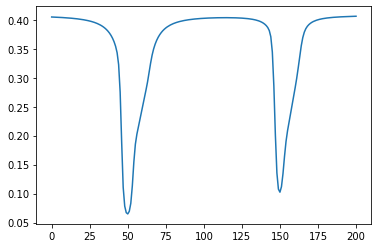

In [18]:
plt.plot(data_norm[0])

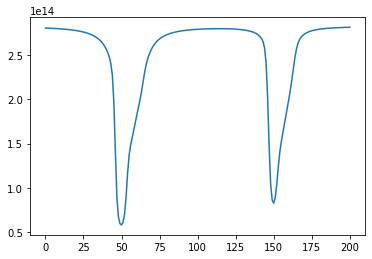

In [16]:
plt.plot(data[0])

In [20]:
data_torch = torch.from_numpy(data_norm.astype('float32'))

In [22]:
test_output = test.forward(data_torch[0:5])

In [24]:
test_output.shape

torch.Size([5, 201])

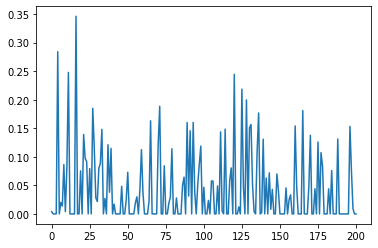

In [26]:
plt.plot(test_output[0].detach().numpy())

In [27]:
del(data_torch)

In [98]:
optimizer = torch.optim.Adam(test.parameters(), lr=5e-3)
loss_fn = nn.MSELoss()

to_train = data_norm[:100000]
to_train_torch = torch.from_numpy(to_train.astype('float32'))
print(to_train_torch.shape)

for loop in range(1000):
    optimizer.zero_grad()        #reset gradients
    out = test.forward(to_train_torch)          #evaluate model
    loss = loss_fn(out, to_train_torch) #calculate loss
    loss.backward()              #calculate gradients
    optimizer.step()             #step fordward
    if loop%10==0: print(f' It : {loop:3d} - loss : {loss.item():.4f} - residual std : {np.sqrt(loss.item()):.4f}')

torch.Size([100000, 201])
 It :   0 - loss : 0.0287 - residual std : 0.1694
 It :  10 - loss : 0.0104 - residual std : 0.1018
 It :  20 - loss : 0.0095 - residual std : 0.0977
 It :  30 - loss : 0.0094 - residual std : 0.0969
 It :  40 - loss : 0.0093 - residual std : 0.0964
 It :  50 - loss : 0.0093 - residual std : 0.0963
 It :  60 - loss : 0.0093 - residual std : 0.0962
 It :  70 - loss : 0.0092 - residual std : 0.0961
 It :  80 - loss : 0.0090 - residual std : 0.0948
 It :  90 - loss : 0.0068 - residual std : 0.0824
 It : 100 - loss : 0.0034 - residual std : 0.0587
 It : 110 - loss : 0.0020 - residual std : 0.0452
 It : 120 - loss : 0.0016 - residual std : 0.0401
 It : 130 - loss : 0.0014 - residual std : 0.0372
 It : 140 - loss : 0.0013 - residual std : 0.0362
 It : 150 - loss : 0.0012 - residual std : 0.0346
 It : 160 - loss : 0.0012 - residual std : 0.0347
 It : 170 - loss : 0.0012 - residual std : 0.0343
 It : 180 - loss : 0.0012 - residual std : 0.0346
 It : 190 - loss : 0.001

In [99]:
test_train = test.forward(to_train_torch[:10])
test_train.shape

torch.Size([10, 201])

In [100]:
bla = test_train.detach().numpy()

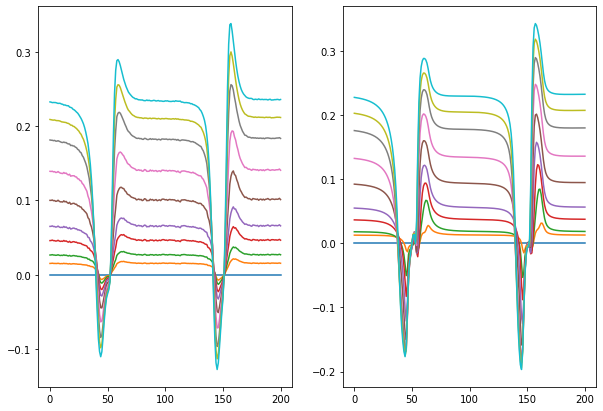

In [101]:
plt.figure(figsize=[10,7])
for i in range(0,10):
    plt.subplot(121)
    plt.plot(bla[i]-bla[0])
    plt.subplot(122)
    plt.plot(data_norm[i]-data_norm[0])
    #plt.plot(to_train_torch[i].detach().numpy(),label='input')
    #plt.legend()

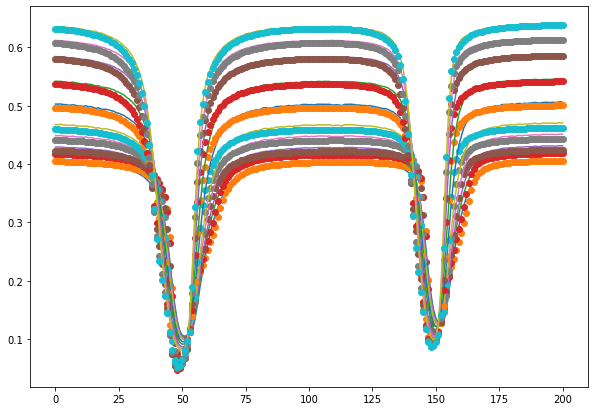

In [102]:
plt.figure(figsize=[10,7])
for i in range(0,10):
    plt.plot(bla[i])
    plt.plot(data_norm[i],'o')
    #plt.plot(to_train_torch[i].detach().numpy(),label='input')
    #plt.legend()